# Data exploration, selection and cleaning

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


DF=pd.read_csv("data/raw/daily/equity/us_equities.csv.gz")
DF.drop('Unnamed: 0', axis=1,inplace=True)  # the first column contains the line number

### 1. Manual exploration of data

In [3]:
print(DF.shape)   # dimensions
print(DF.head())



(16291, 1053)
   ^GSPC  GE  IBM  DIS  BA  CAT  AA  HPQ  DD  KO  ...  CTX  CTR  DYN  AIB  \
0  16.66 NaN  NaN  NaN NaN  NaN NaN  NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
1  16.85 NaN  NaN  NaN NaN  NaN NaN  NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
2  16.93 NaN  NaN  NaN NaN  NaN NaN  NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
3  16.98 NaN  NaN  NaN NaN  NaN NaN  NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
4  17.08 NaN  NaN  NaN NaN  NaN NaN  NaN NaN NaN  ...  NaN  NaN  NaN  NaN   

   PCU  KIM  SFN  AMR  TCO   S  
0  NaN  NaN  NaN  NaN  NaN NaN  
1  NaN  NaN  NaN  NaN  NaN NaN  
2  NaN  NaN  NaN  NaN  NaN NaN  
3  NaN  NaN  NaN  NaN  NaN NaN  
4  NaN  NaN  NaN  NaN  NaN NaN  

[5 rows x 1053 columns]


Thus columns names are asset symbols. ^GSPC is the S&P500 index, GE is General Electric, IBM is IBM, CAT Caterpillar. So it seems that this really is a US equities dataset. The data itself is probably a price. Dates are missing. There are also many missing values. Let us see how much data is missing as a function of time:

Text(0, 0.5, 'log ^GSPC')

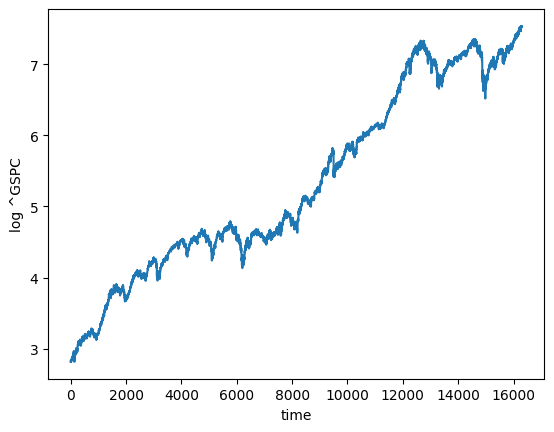

In [4]:
np.log(DF["^GSPC"]).plot()  
plt.xlabel("time")
plt.ylabel("log ^GSPC")

This looks very much like the real ^GSPC, and dates include 2008.

Text(0, 0.5, 'log-returns ^GSPC')

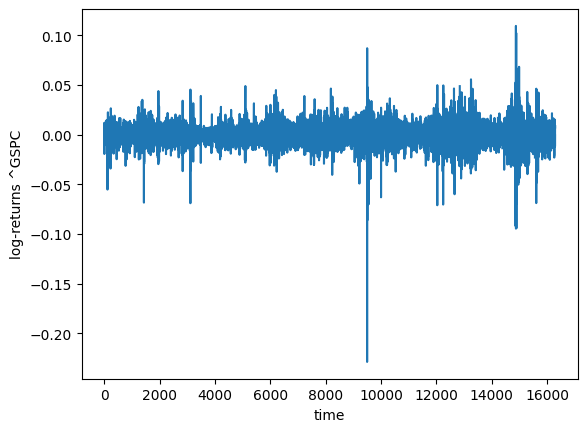

In [5]:
np.log(DF["^GSPC"]).diff().plot()
plt.xlabel("time")
plt.ylabel("log-returns ^GSPC")

### 2. Missing data

Text(0, 0.5, 'number of NA cols')

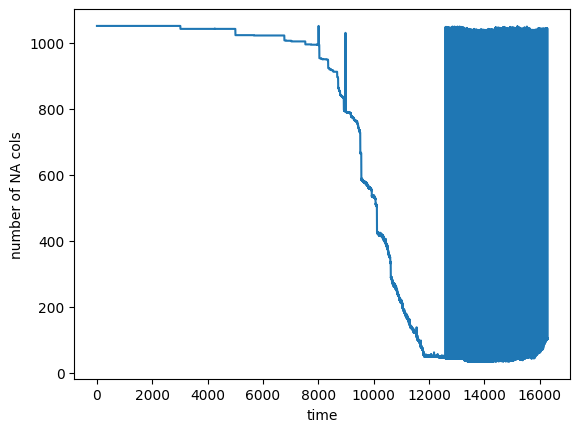

In [6]:
missingDataPerLine = DF.isnull().sum(axis=1) 

plt.plot(missingDataPerLine)
plt.xlabel("time")
plt.ylabel("number of NA cols")



### 3. Remove unwanted lines and columns

In [7]:
#when ^GSPC is NA
special_lines=DF["^GSPC"].isnull()

#what is not NA when ^GSPC is NA
DF[special_lines].notnull()

#sum by column
is_asset_special=DF[special_lines].notnull().sum(axis=0)>0

#special assets are then easily obtained
special_assets=DF.columns[is_asset_special]
print(special_assets)

Index(['BAX', 'TAP', 'WRB', 'AVY', 'ATO', 'AJG', 'AIT', 'B', 'BMI', 'AZZ',
       'CAS', 'ARL', 'CBT', 'BCE', 'GAS', 'AEM', 'BEN', 'ABX', 'AM', 'BBY',
       'PRX', 'BRC', 'AEG', 'SUN', 'SOV', 'SGR', 'LIZ', 'ABK', 'ID', 'TKS',
       'BMT', 'TBL', 'SBG', 'SEL', 'PPD', 'TPP', 'ARA', 'CXR', 'WYE', 'PCU',
       'AMR'],
      dtype='object')


In [8]:
#Remove all columns of the special assets
DF.drop(columns=special_assets,inplace=True)


In [9]:
#Remove special lines
DF=DF[DF["^GSPC"].notnull()]

In [10]:
#log returns of all the columns at once
r=np.log(DF).diff()

/home/damien/anaconda3/envs/tf2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


### 4. Tame outliers

In [11]:
theta=0.15  # arbirary.

#the Pandas' way
r.clip(-theta,theta,inplace=True)

#the logical way
sel_outliers=np.abs(r)>theta
r[sel_outliers]=np.sign(r[sel_outliers])*theta

The problem here is that the prices of US equities are not adjusted for splits, dividends, and other corporate events. This induces artificial jumps and biases the dataset.

In [16]:
%%time
r.to_csv("data/clean/us_equities_logreturns.csv.gz")   # slow

CPU times: user 33.8 s, sys: 74.3 ms, total: 33.8 s
Wall time: 33.8 s


In [15]:
%%time
r.to_parquet("data/clean/us_equities_logreturns.parquet")  # much faster 

CPU times: user 838 ms, sys: 125 ms, total: 963 ms
Wall time: 965 ms


### 5. Add dates
Finally, one can add the dates. Two methods: if the prices are the correct ones, then download data for ^GSPC from some other source and align the two to find the starting date (and double check with other dates)

In [15]:
import yfinance as yf

GSPC = yf.Ticker("^GSPC")

# get stock info
GSPC.info

# get historical market data
GSPC_yf = GSPC.history(period="max")

# show actions (dividends, splits)
GSPC.actions


,Dividends,Stock Splits
Date,,


In [16]:
import numpy as np
import pandas as pd

r=(np.log(GSPC_yf["Close"]/GSPC_yf["Open"]))


                                Open       High        Low      Close  Volume  \
Date                                                                            
1927-12-30 00:00:00-05:00  17.660000  17.660000  17.660000  17.660000       0   
1928-01-03 00:00:00-05:00  17.760000  17.760000  17.760000  17.760000       0   
1928-01-04 00:00:00-05:00  17.719999  17.719999  17.719999  17.719999       0   
1928-01-05 00:00:00-05:00  17.549999  17.549999  17.549999  17.549999       0   
1928-01-06 00:00:00-05:00  17.660000  17.660000  17.660000  17.660000       0   

                           Dividends  Stock Splits  
Date                                                
1927-12-30 00:00:00-05:00        0.0           0.0  
1928-01-03 00:00:00-05:00        0.0           0.0  
1928-01-04 00:00:00-05:00        0.0           0.0  
1928-01-05 00:00:00-05:00        0.0           0.0  
1928-01-06 00:00:00-05:00        0.0           0.0  


/home/damien/anaconda3/envs/b3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


<Axes: xlabel='Date'>

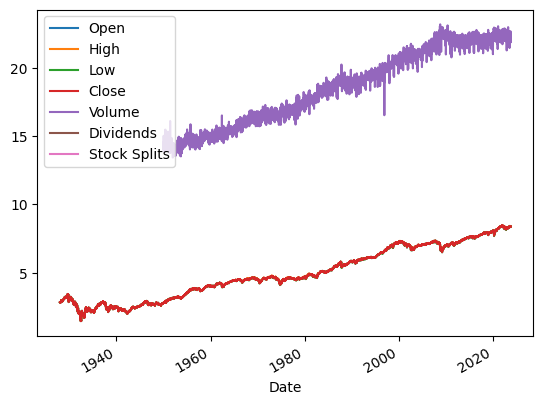

In [18]:
print(GSPC_yf.head())


np.log(GSPC_yf).plot()

It is clear than the data from Yahoo Finance starts before that of us-equities. Let us now find the 

In [19]:
DF["^GSPC"].values[100]


18.67

In [26]:
np.sum(np.abs(DF["^GSPC"].values[0]-GSPC_yf["Close"].values)<0.000001)

7

In [27]:
GSPC_yf.index[np.abs(DF["^GSPC"].values[0]-GSPC_yf["Close"].values)<0.000001]

DatetimeIndex(['1930-11-18 00:00:00-05:00', '1931-03-30 00:00:00-05:00',
               '1937-08-19 00:00:00-04:00', '1945-10-17 00:00:00-05:00',
               '1949-12-16 00:00:00-05:00', '1949-12-28 00:00:00-05:00',
               '1950-01-03 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', freq=None)

So it seems that US equities start at 1950-01-03. 

In [31]:
#GSPC_yf contains more lines than DF, so only keep the relevant index lines 
idx_start=np.where(np.abs(DF["^GSPC"].values[0]-GSPC_yf["Close"].values)<0.000001)[0][-1]
DF.index=GSPC_yf.index[range(idx_start,idx_start+DF.shape[0])]

In [32]:
DF["^GSPC"].loc["2008-10-03"]

1099.23

In [33]:
GSPC_yf.loc["2008-10-03"]

Open            1.115160e+03
High            1.153820e+03
Low             1.098140e+03
Close           1.099230e+03
Volume          6.716120e+09
Dividends       0.000000e+00
Stock Splits    0.000000e+00
Name: 2008-10-03 00:00:00-04:00, dtype: float64

Thus, US equities contains close prices. Are they adjusted close prices? To answer this question, one needs to compare DF data with an asset which experienced corporate actions.

In [34]:
IBM=yf.Ticker("IBM")
IBM_yf=IBM.history("max")    # adjusted prices

In [35]:
DF["IBM"].loc["2008-10-03"]

93.37

In [36]:
IBM_yf.loc["2008-10-03"]["Close"]

59.655067443847656

So clearly there is a discrepancy. IBM_yf reports adjusted prices. What happens is that the prices of IBM have been adjusted (dividends, splits) after the end of US equities.

Date
1962-01-02 00:00:00-05:00    1.569838
1962-01-03 00:00:00-05:00    1.568836
1962-01-04 00:00:00-05:00    1.571899
1962-01-05 00:00:00-05:00    1.571019
1962-01-08 00:00:00-05:00    1.567959
                               ...   
2014-03-12 00:00:00-04:00    1.565130
2014-03-13 00:00:00-04:00    1.565130
2014-03-14 00:00:00-04:00    1.565130
2014-03-17 00:00:00-04:00    1.565130
2014-03-18 00:00:00-04:00    1.565130
Length: 13142, dtype: float64


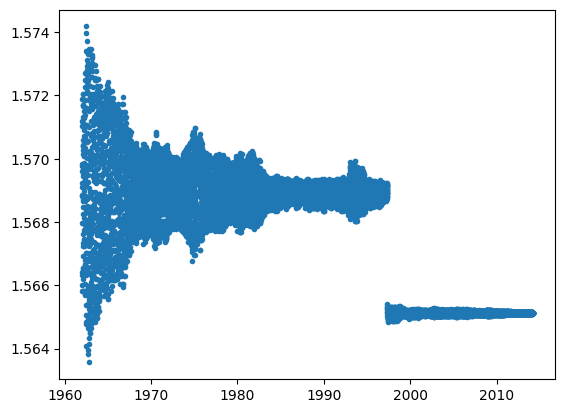

In [37]:
#discrepancy factor

price_ratio=(DF["IBM"]/IBM_yf["Close"]).dropna()
print(price_ratio)


plt.plot(price_ratio,".")

Thus, US equities is randomly adjusted and thus not suitable for investment purposes: never trust data that is given to you. Let us however try to understand were the 1.25 factor comes from: first, not from splits, since no split occurs after 2014-03-18

In [38]:
IBM.splits

Date
1964-05-18 00:00:00-04:00    1.250
1966-05-18 00:00:00-04:00    1.500
1968-04-23 00:00:00-05:00    2.000
1973-05-29 00:00:00-04:00    1.250
1979-06-01 00:00:00-04:00    4.000
1997-05-28 00:00:00-04:00    2.000
1999-05-27 00:00:00-04:00    2.000
2021-11-04 00:00:00-04:00    1.046
Name: Stock Splits, dtype: float64

Let us compute the dividend adjustments from 2014-03-19 to the end. We must first download raw prices.

In [39]:
IBM_yf_not_adj=IBM.history("max",auto_adjust=False)

In [40]:
#compte the total adjustement due to dividends. Dividends are given in $ and are not adjusted
1/np.prod(1-(IBM.dividends["2014-03-19":]/IBM_yf_not_adj["Close"]).dropna())

1.5048327015505307

Thus we have 

In [42]:
1.565130/1.5048327015505307


1.0400691042847094

We are clearly progressing. The rest is probably not worth it.